In [58]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from ibm_watson import PersonalityInsightsV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import json
import matplotlib 
import matplotlib.pyplot as plt
import kaggle
from os.path import expanduser
from glob import glob
%matplotlib inline

In [3]:
kaggle.api.authenticate()

kaggle.api.dataset_download_files('andradaolteanu/rickmorty-scripts', path=expanduser('~/TMP/r_n_morty'), unzip=True)

for name in glob(expanduser('~/TMP/r_n_morty/*')):
    if '.csv' in name:
        rnm_s123_data = pd.read_csv(name)

In [5]:
rnm_s4e10_beth_data = pd.read_csv('/Users/simonlipson/Downloads/rick an morty beth lines - Sheet1.csv')

In [6]:
rnm_s4e10_beth_data

,character,line
0,family_beth,Dr. Wong had a cancellation today. Anybody up ...
1,family_beth,"Great, because she specifically asked you to s..."
2,family_beth,Share the invisibility. Jerry?
3,family_beth,You're a bad father
4,family_beth,Dad? We're off to Dr. Wong's.
...,...,...
69,space_beth,That works for me... I was just gonna give you...
70,space_beth,"What's this, Dad?"
71,space_beth,You mind-blew yourself? You... You literally d...
72,space_beth,"Yeah, me neither. You're a piece of shit eithe..."


In [23]:
rnm_s123_data.columns

Index(['index', 'season no.', 'episode no.', 'episode name', 'name', 'line'], dtype='object')

In [24]:
rnm_s4e10_beth_data.columns = ['name', 'line']

In [107]:
rnm_s4e10_beth_data.head()

,name,line
0,family_beth,Dr. Wong had a cancellation today. Anybody up ...
1,family_beth,"Great, because she specifically asked you to s..."
2,family_beth,Share the invisibility. Jerry?
3,family_beth,You're a bad father
4,family_beth,Dad? We're off to Dr. Wong's.


In [29]:
rnm_s123_beth = rnm_s123_data.loc[rnm_s123_data['name']=='Beth'][['name', 'line']]

In [34]:
real_beth = ' '.join(rnm_s123_data['line']
                     .tolist())

In [40]:
family_beth = ' '.join(rnm_s4e10_beth_data
                       .loc[rnm_s4e10_beth_data['name']=='family_beth']['line']
                       .tolist())

In [41]:
space_beth = ' '.join(rnm_s4e10_beth_data
                       .loc[rnm_s4e10_beth_data['name']=='space_beth']['line']
                       .tolist())

In [42]:
authenticator = IAMAuthenticator('Be785piW-5_PT6GVRQwXFX5tHCD-zTtL0cfESb9j3sV6')
service = PersonalityInsightsV3(authenticator = authenticator, version='2017-10-13')
service.set_service_url('https://api.eu-gb.personality-insights.watson.cloud.ibm.com/instances/636a8bd3-1de0-4bb5-bd45-748b1c2afa4d')
service

In [44]:
beths = ['real_beth', 'family_beth', 'space_beth']

for beth in beths:
    globals()[beth + '_profile'] = service.profile(
                                                    globals()[beth],
                                                    'application/json',
                                                    consumption_preferences=True,
                                                    raw_scores=True
                                                    ).get_result()
    print(len(globals()[beth + '_profile']))

7
8
8


In [156]:
def create_personality_plot(level):
    labels = [big5['name'] for big5 in real_beth_profile[level]]
    real_beth_p = [big5['percentile'] for big5 in real_beth_profile[level]]
    family_beth_p = [big5['percentile'] for big5 in family_beth_profile[level]]
    space_beth_p = [big5['percentile'] for big5 in space_beth_profile[level]]

    barWidth = 0.20  # the width of the bars

    # Set position of bar on X axis
    r1 = np.arange(len(real_beth_p))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Make the plot
    plt.bar(r1, real_beth_p, color='#cc6600', width=barWidth, edgecolor='white', label='real_beth')
    plt.bar(r2, family_beth_p, color='#cccc00', width=barWidth, edgecolor='white', label='family_beth')
    plt.bar(r3, space_beth_p, color='#66cc00', width=barWidth, edgecolor='white', label='space_beth')


    # Add xticks on the middle of the group bars
    plt.xlabel(level, fontweight = 'bold')
    plt.xticks([r + barWidth for r in range(len(real_beth_p))], labels)
    plt.rcParams["figure.figsize"] = (30,8)
    matplotlib.rcParams.update({'font.size': 20})
    plt.ylabel('Percentile', fontweight = 'bold')

    # Create legend & Show graphic
    plt.legend()
    plt.show()


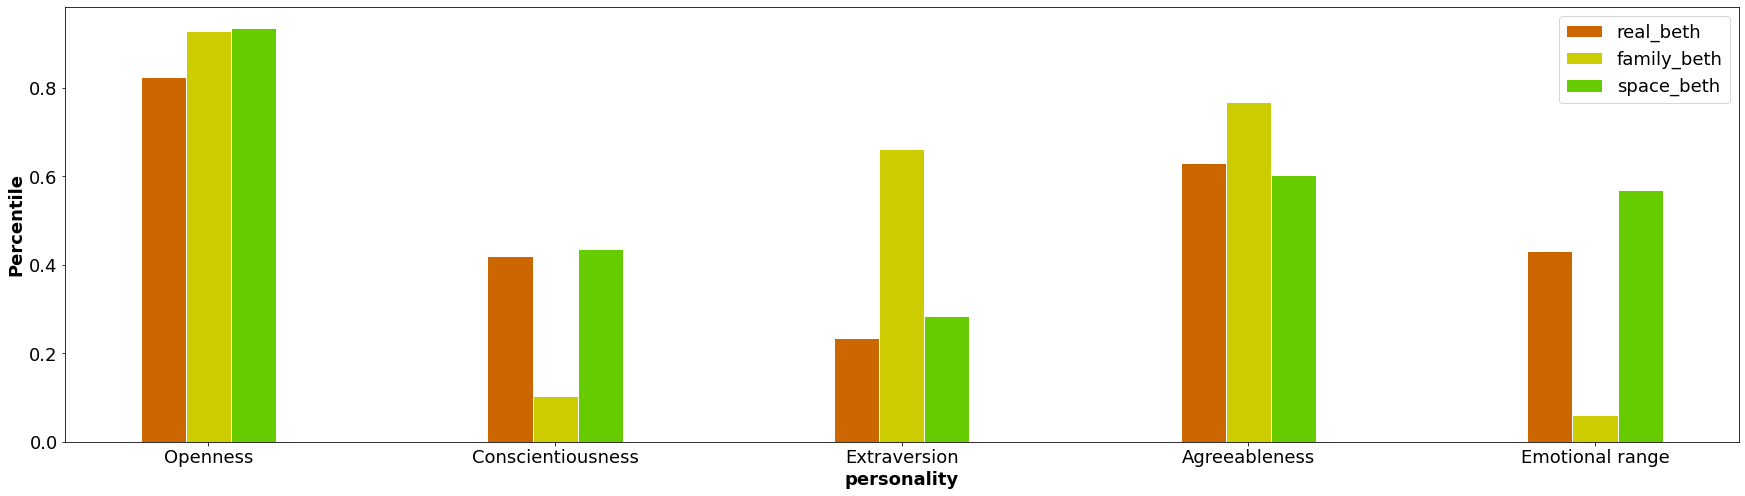

In [71]:
create_personality_plot('personality')

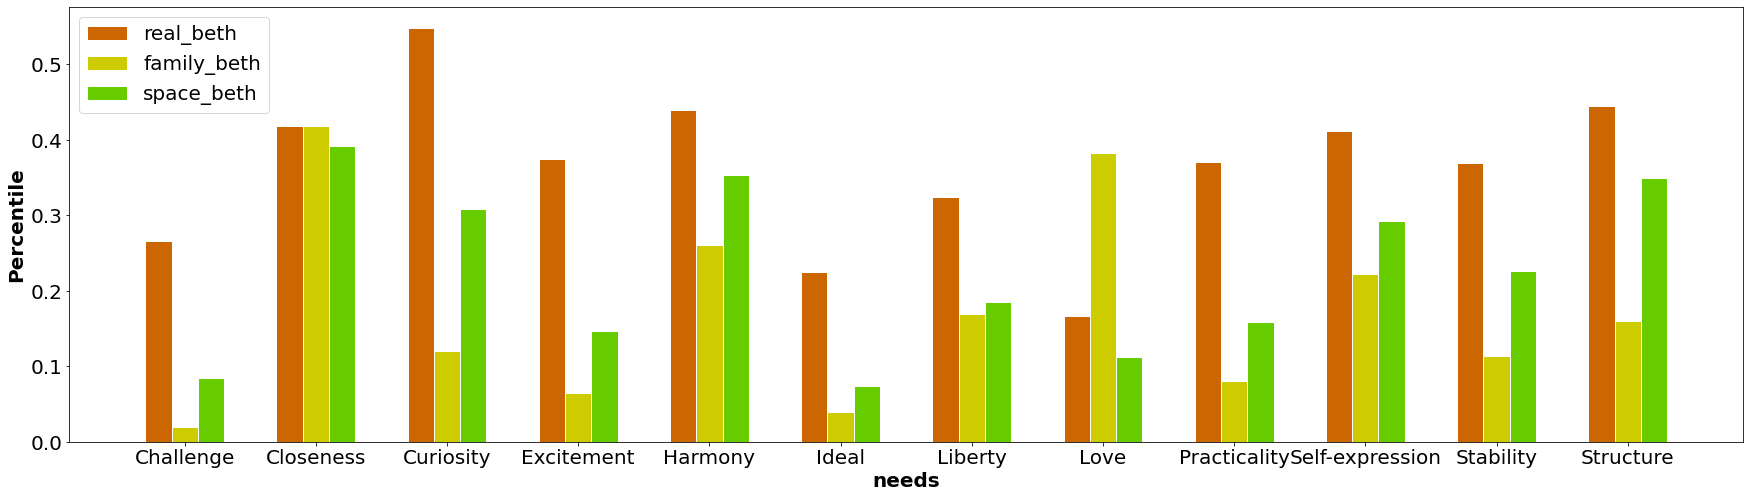

In [158]:
create_personality_plot('needs')

## Classifying Real Beth as either Family Beth or Space Beth

Here I will train a classifyer on family_beth and space_beth. I can

In [139]:
X_train = rnm_s4e10_beth_data['line']
X_test = rnm_s123_beth['line']
y_train = rnm_s4e10_beth_data['name']
y_test = rnm_s123_beth['name']

In [140]:
tfv = TfidfVectorizer(ngram_range=(2,4), max_features=1408)
X_train = tfv.fit_transform(X_train).todense()
X_test = tfv.fit_transform(X_test).todense()
print(X_train.shape)
print(X_test.shape)

(74, 1408)
(149, 1408)


In [141]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [147]:
y_pred_prob = model.predict_proba(X_test)
result = pd.DataFrame(y_pred_prob, columns=['family_beth_probability', 'space_beth_probability'])

In [149]:
result = pd.DataFrame(y_pred_prob, columns=['family_beth_probability', 'space_beth_probability'])

In [154]:
result['family_beth_probability'].mean()

0.3987001057093412

In [155]:
result['space_beth_probability'].mean()

0.6012998942906588